In [1]:
# general python modules
import sys, os, pprint, pandas
import numpy as np
import matplotlib.pylab as plt
from scipy import stats

sys.path.append('../physion/src')
from physion.analysis.read_NWB import Data, scan_folder_for_NWBfiles
from physion.analysis.process_NWB import EpisodeData
sys.path.append('../')
import plot_tools as pt

from analysis import compute_tuning_response_per_cells, shift_orientation_according_to_pref

root_folder = os.path.join(os.path.expanduser('~'), 'DATA', 'SST-WT-GluN1-ffGratings-2024')

## Build the dataset from the NWB files

In [2]:
DATASET = {\
    'WT':scan_folder_for_NWBfiles(os.path.join(root_folder, 'Wild-Type')),
    'KO':scan_folder_for_NWBfiles(os.path.join(root_folder, 'GluN1-KO')),
}

inspecting the folder "/Users/yann/DATA/SST-WT-GluN1-ffGratings-2024/Wild-Type" [...]
 -> found n=18 datafiles (in 1.2s) 
inspecting the folder "/Users/yann/DATA/SST-WT-GluN1-ffGratings-2024/GluN1-KO" [...]
 -> found n=14 datafiles (in 0.9s) 


In [3]:
# -------------------------------------------------- #
# ----   Loop over datafiles               --------- #
# -------------------------------------------------- #

dFoF_parameters = dict(\
        roi_to_neuropil_fluo_inclusion_factor=1.15,
        neuropil_correction_factor = 0.7,
        method_for_F0 = 'sliding_percentile',
        percentile=5., # percent
        sliding_window = 5*60, # seconds
)

stat_test_props=dict(interval_pre=[-1.,0],                                   
                   interval_post=[1.,2.],                                   
                   test='anova',                                            
                   positive=True)

response_significance_threshold=5e-2


def orientation_selectivity_index(resp_pref, resp_90):
    """                                                                         
     computes the selectivity index: (Pref-Orth)/Pref
     clipped in [0,1] --> because resp_90 can be negative    
    """
    return (resp_pref-np.clip(resp_90, 0, np.inf))/resp_pref

def compute_summary_responses(DATASET,
                              Nmax=999, # max datafiles (for debugging)
                              verbose=True):
    
    SUMMARY = {}
    
    SUMMARY['dFoF_args'] = dFoF_parameters
    
    for key in ['WT', 'KO']:
        SUMMARY[key] = {'subjects':[], 'tstart':[], 'tstop':[]}
        
        for contrast in [0.5, 1]:
            SUMMARY[key]['RESPONSES_c=%.1f' % contrast], SUMMARY[key]['OSI_c=%.1f' % contrast] = [], []
            SUMMARY[key]['FRAC_RESP_c=%.1f' % contrast], SUMMARY[key]['SIGNIFICANT_c=%.1f' % contrast] = [], []
            
        for f, s in zip(DATASET[key]['files'][:Nmax], DATASET[key]['subjects'][:Nmax]):
            SUMMARY[key]['subjects'].append(s)
            print('analyzing "%s" [...] ' % f)
            data = Data(f, verbose=False)
            
            data.build_dFoF(**dFoF_parameters, verbose=False)
            data.init_visual_stim()
            #Dcnv = oasis(data.dFoF, data.dFoF.shape[0], TAU_DECONVOLUTION, 1./data.CaImaging_dt)

            protocol = 'ff-gratings-8orientation-2contrasts-15repeats' if\
                        ('ff-gratings-8orientation-2contrasts-15repeats' in data.protocols) else\
                        'ff-gratings-8orientation-2contrasts-10repeats'

            pCond = data.get_protocol_cond(protocol_id=data.get_protocol_id(protocol_name=protocol))
            # start and stop of the grating protocol (in case of rec. with other protocols)
            SUMMARY[key]['tstart'].append(np.min(data.visual_stim.experiment['time_start'][:len(pCond)][pCond]))
            SUMMARY[key]['tstop'].append(np.max(data.visual_stim.experiment['time_stop'][:len(pCond)][pCond]))
            
            for contrast in [0.5, 1]:
                
                responses, significant, shifted_angle = compute_tuning_response_per_cells(data,
                                                                                          imaging_quantity='dFoF',
                                                                                          contrast=contrast,
                                                                                          protocol_name=protocol,
                                                                                          stat_test_props=stat_test_props,
                                                                                          response_significance_threshold=\
                                                                                                      response_significance_threshold,
                                                                                          verbose=False)
                
                SUMMARY[key]['RESPONSES_c=%.1f' % contrast].append(responses)
                SUMMARY[key]['FRAC_RESP_c=%.1f' % contrast].append(np.sum(significant)/len(significant))
                SUMMARY[key]['SIGNIFICANT_c=%.1f' % contrast].append(significant)
                SUMMARY[key]['OSI_c=%.1f' % contrast].append([orientation_selectivity_index(r[1], r[5]) for r in responses])

                
    SUMMARY['shifted_angle'] = shifted_angle
    print('done ! ')
    
    return SUMMARY

SUMMARY = compute_summary_responses(DATASET,
                                    verbose=False)
np.save('../data/in-vivo/summary-episodes.npy', SUMMARY)

analyzing "/Users/yann/DATA/SST-WT-GluN1-ffGratings-2024/Wild-Type/sub-01/sub-01_ses-01_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/DATA/SST-WT-GluN1-ffGratings-2024/Wild-Type/sub-01/sub-01_ses-02_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/DATA/SST-WT-GluN1-ffGratings-2024/Wild-Type/sub-01/sub-01_ses-03_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/DATA/SST-WT-GluN1-ffGratings-2024/Wild-Type/sub-01/sub-01_ses-04_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/DATA/SST-WT-GluN1-ffGratings-2024/Wild-Type/sub-02/sub-02_ses-01_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/DATA/SST-WT-GluN1-ffGratings-2024/Wild-Type/sub-02/sub-02_ses-02_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/DATA/SST-WT-GluN1-ffGratings-2024/Wild-Type/sub-02/sub-02_ses-03_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/DATA/SST-WT-GluN1-ffGratings-2024/Wild-Type/sub-02/sub-02_ses-04_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/User

# Responsiveness to visual stimulation

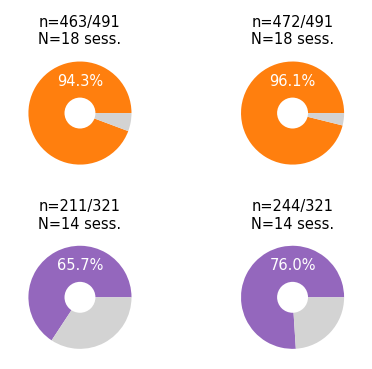

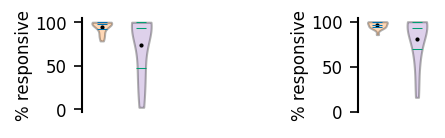

In [4]:
from scipy import stats

SUMMARY = np.load('../data/in-vivo/summary-episodes.npy', allow_pickle=True).item()

fig1, AX1 = pt.figure(axes=(2,2),figsize=(1.,1.2))

cases, colors = ['WT', 'KO'], ['tab:orange', 'tab:purple']

for i, case in enumerate(cases):
    for c, contrast in enumerate([0.5, 1.0]):
        resp = np.sum([np.sum(r) for r in SUMMARY[case]['SIGNIFICANT_c=%.1f' % contrast]])
        tot = np.sum([len(r) for r in SUMMARY[case]['SIGNIFICANT_c=%.1f' % contrast]])
        pt.pie([100*resp/tot, 100*(1-resp/tot)], ax=AX1[i][c], COLORS=[colors[i], 'lightgrey'])
        pt.annotate(AX1[i][c], '%.1f%%' % (100*resp/tot), (.5,.85), va='top', ha='center',color='w', fontsize=7)
        AX1[i][c].set_title('n=%i/%i\nN=%i sess.' % (resp,tot,len(SUMMARY[case]['SIGNIFICANT_c=%.1f' % contrast])), fontsize=7)

fig2, AX2 = pt.figure(axes=(2,1), figsize=(.6,1.), wspace=5.)
for c, contrast in enumerate([0.5, 1.0]):
    for i, case in enumerate(cases):
        frac = 100*np.mean([r for r in SUMMARY[case]['FRAC_RESP_c=%.1f' % contrast]])
        pt.violin(100*np.array(SUMMARY[case]['FRAC_RESP_c=%.1f' % contrast]),
                  X=[i], COLORS=[colors[i]], ax=AX2[c])
    pt.set_plot(AX2[c], ['left'], ylabel='% responsive', yticks=[0,50,100])
stats.mannwhitneyu(SUMMARY['WT']['FRAC_RESP_c=1.0'], SUMMARY['KO']['FRAC_RESP_c=1.0'])

fig1.savefig('../figures/in-vivo/summary-responsiveness.svg')
fig1.savefig('../figures/Figure7/summary-responsiveness.pdf')

# Temporal Dynamics of Visually-Evoked Responses

In [5]:
TAU_DECONVOLUTION = 1.5

dFoF_parameters['smoothing'] = 1.5

def compute_summary_responses(DATASET,
                              Nmax=999, # max datafiles (for debugging)
                              verbose=True):
    
    SUMMARY = np.load('../data/in-vivo/summary-episodes.npy', allow_pickle=True).item()

    SUMMARY['dFoF_args'] = dFoF_parameters
    
    for key in ['WT', 'KO']:
        SUMMARY[key]['subjects'] = []
        SUMMARY[key]['tstart'] = []
        SUMMARY[key]['tstop'] = []
        
        for contrast in [0.5, 1]:
            SUMMARY[key]['WAVEFORMS_c=%.1f' % contrast] = []
            
        for f, s, significant in zip(DATASET[key]['files'][:Nmax],
                                     DATASET[key]['subjects'],
                                     SUMMARY[key]['SIGNIFICANT_c=1.0']):
            
            SUMMARY[key]['subjects'].append(s)
            print('analyzing "%s" [...] ' % f)
            data = Data(f, verbose=False)
            
            data.build_dFoF(**dFoF_parameters, verbose=False)
            data.build_Deconvolved(Tau=TAU_DECONVOLUTION)
            data.init_visual_stim()

            protocol = 'ff-gratings-8orientation-2contrasts-15repeats' if\
                        ('ff-gratings-8orientation-2contrasts-15repeats' in data.protocols) else\
                        'ff-gratings-8orientation-2contrasts-10repeats'

            for contrast in [0.5, 1]:
                
                t, significant_waveforms = compute_tuning_response_per_cells(data,
                                                                             prestim_duration=2.5,
                                                                             imaging_quantity='Deconvolved',
                                                                             contrast=contrast,
                                                                             protocol_name=protocol,
                                                                             stat_test_props=stat_test_props,
                                                                             response_significance_threshold=\
                                                                                          response_significance_threshold,
                                                                             verbose=False,
                                                                             return_significant_waveforms=True)
                
                SUMMARY[key]['WAVEFORMS_c=%.1f' % contrast].append(significant_waveforms)
                
    SUMMARY['t'] = t
    print('done ! ')
    
    return SUMMARY

SUMMARY = compute_summary_responses(DATASET,
                                    verbose=False)
np.save('../data/in-vivo/summary-deconvolved.npy', SUMMARY)

analyzing "/Users/yann/DATA/SST-WT-GluN1-ffGratings-2024/Wild-Type/sub-01/sub-01_ses-01_V1-ffGratingStim-2Prec.nwb" [...] 


/Users/yann/miniconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


analyzing "/Users/yann/DATA/SST-WT-GluN1-ffGratings-2024/Wild-Type/sub-01/sub-01_ses-02_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/DATA/SST-WT-GluN1-ffGratings-2024/Wild-Type/sub-01/sub-01_ses-03_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/DATA/SST-WT-GluN1-ffGratings-2024/Wild-Type/sub-01/sub-01_ses-04_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/DATA/SST-WT-GluN1-ffGratings-2024/Wild-Type/sub-02/sub-02_ses-01_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/DATA/SST-WT-GluN1-ffGratings-2024/Wild-Type/sub-02/sub-02_ses-02_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/DATA/SST-WT-GluN1-ffGratings-2024/Wild-Type/sub-02/sub-02_ses-03_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/DATA/SST-WT-GluN1-ffGratings-2024/Wild-Type/sub-02/sub-02_ses-04_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/DATA/SST-WT-GluN1-ffGratings-2024/Wild-Type/sub-03/sub-03_ses-01_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/User

In [6]:
from scipy.optimize import minimize

def gaussian(t, X):
    return (1-X[1])*np.exp(-t**2/2/X[0]**2)+X[1]
                 
def fit_gaussian_width(shift, array,
                       min_time=0.1,
                       max_time=2.5):
    def func(X):
        return np.sum(np.abs(gaussian(shift, X)-array/np.max(array)))
    res = minimize(func, [3*min_time,0,1],
                   bounds=[[min_time, max_time],
                           [-max_time, max_time],
                           [0,1]], method='L-BFGS-B')
    return res.x

KO 0.77 +/- 0.18 ms
WT 1.66 +/- 0.20 ms


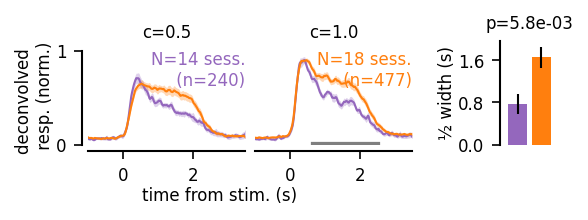

In [8]:
SUMMARY = np.load('../data/in-vivo/summary-deconvolved.npy', allow_pickle=True).item()

fig, AX = pt.figure(axes=(2,1),figsize=(1.1,1.),wspace=0.1, right=7.)

cases, colors = ['KO', 'WT'], ['tab:purple', 'tab:orange']

inset = pt.inset(AX[1], [1.6,0.,0.3,1.1])

fitInterval = [0.7, 2.5]
Widths = {}
for i, case in enumerate(cases):
    Widths[case] = []
    c1 = [np.mean(r, axis=0) for r in SUMMARY[case]['WAVEFORMS_c=1.0']]
    for c, contrast in enumerate([0.5, 1.0]):

        resp = [np.mean(r, axis=0) for r in SUMMARY[case]['WAVEFORMS_c=%.1f' % contrast]]
        #resp = np.divide(resp, np.max(resp, axis=1, keepdims=True))
        resp = np.divide(resp, np.max(c1, axis=1, keepdims=True))
        
        pt.plot(SUMMARY['t'], np.mean(resp, axis=0),#/np.mean(responsive_CCs, axis=0).max(),
                sy=stats.sem(resp, axis=0),
                #sy=np.std(resp, axis=0),
                color=colors[i], ax=AX[c])
        if c:
            pt.annotate(AX[i],'N=%i sess.' % len(SUMMARY[case]['WAVEFORMS_c=%.1f' % contrast]),
                        (1,1), va='top', ha='right', color=colors[i])
    # fit here, i.e. at full contrast
    cond = (SUMMARY['t']>fitInterval[0]) & (SUMMARY['t']<fitInterval[1]) 
    for iSession in range(len(resp)):
        Widths[case].append(fit_gaussian_width(SUMMARY['t'][cond]-fitInterval[0],
                            resp[iSession][cond]/np.max(resp[iSession]
                                                        [cond]))[0])
    print(case, '%.2f +/- %.2f ms' % (np.mean(Widths[case]), stats.sem(Widths[case])))
    inset.bar([i], [np.mean(Widths[case])], yerr=[stats.sem(Widths[case])], color=colors[i])

AX[1].plot(fitInterval, [0,0], 'k-', lw=3, alpha=0.5)

pt.set_plot(inset, ['left'], 
            title='p=%.1e' % stats.mannwhitneyu(Widths['WT'], Widths['KO']).pvalue,
            ylabel=u'\u00bd' + ' width (s)')

for c, contrast in enumerate([0.5, 1.0]):
    pt.set_plot(AX[c], ['left','bottom'] if c==0 else ['bottom'],
                xlim=[-1,3.5], yticks=[0,1], xticks=[0,2],
                yticks_labels=['0','1'] if c==0 else [],
                ylim=[0,1], 
                ylabel='deconvolved \n resp. (norm.)' if c==0 else '',
                title='c=%.1f' % contrast,
                xlabel=20*' '+'time from stim. (s)' if c==0 else '')
fig.savefig('../figures/in-vivo/summary-evoked-resp.svg')
fig.savefig('../figures/Figure7/summary-evoked-resp.pdf')

In [20]:
[len(r) for r in SUMMARY['WT']['RESPONSES_c=1.0']]

[12, 11, 39, 43, 28, 29, 38, 30, 26, 27, 26, 30, 15, 32, 13, 17, 36, 20]

In [25]:
[len(r) for r in SUMMARY['WT']['WAVEFORMS_c=1.0']]

[13, 11, 39, 43, 28, 27, 39, 31, 27, 27, 27, 33, 15, 32, 13, 17, 35, 20]

In [26]:
[len(r) for r in SUMMARY['WT']['SIGNIFICANT_c=1.0']]

[13, 11, 40, 45, 28, 29, 40, 32, 28, 27, 27, 35, 15, 32, 14, 17, 37, 21]

# Orientation tuning

WT c=1.0 average by: sessions , OSI= 0.51 +/- 0.02
KO c=1.0 average by: sessions , OSI= 0.66 +/- 0.05
Mann-Whitney: p=3.2e-02

WT c=1.0 average by: ROIs , OSI= 0.49 +/- 0.01
KO c=1.0 average by: ROIs , OSI= 0.56 +/- 0.02
Mann-Whitney: p=4.7e-04

WT c=1.0 average by: sessions , OSI= 0.51 +/- 0.02
WT c=0.5 average by: sessions , OSI= 0.61 +/- 0.02
Mann-Whitney: p=6.8e-03

WT c=1.0 average by: ROIs , OSI= 0.49 +/- 0.01
WT c=0.5 average by: ROIs , OSI= 0.56 +/- 0.01
Mann-Whitney: p=3.0e-06



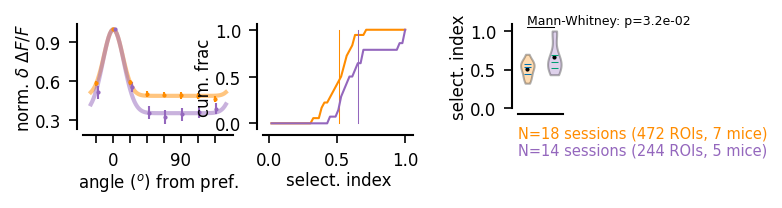

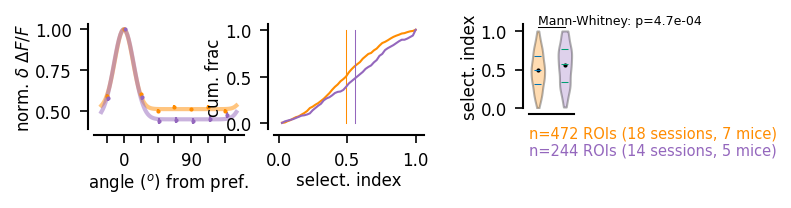

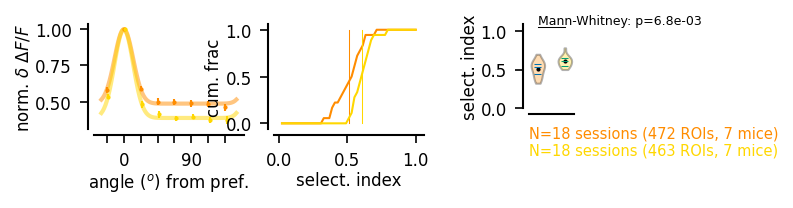

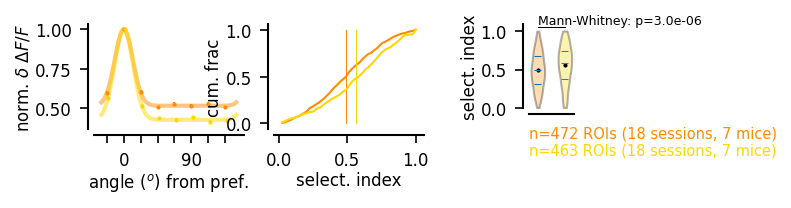

In [7]:
from scipy.optimize import minimize

def func(S, X):
    """ fitting function """
    nS = (S+90)%180-90
    return X[0]*np.exp(-(nS**2/2./X[1]**2))+X[2]

def selectivity_index(resp1, resp2):
    return (resp1-np.clip(resp2, 0, np.inf))/resp1

def generate_comparison_figs(SUMMARY, cases, contrasts,
                             average_by='ROIs',
                             colors=['k', 'tab:blue', 'tab:green'],
                             norm='',
                             ms=1):
    
    fig, [ax,ax2] = plt.subplots(1, 2, figsize=(8, 1))
    plt.subplots_adjust(top=0.9, bottom=0.2, right=0.4)
    inset = pt.inset(ax2, (1.7, 0.2, 0.3, 0.8))

    SIs = []
    for i, key, contrast in zip(range(2), cases, contrasts):

        if average_by=='sessions':
            resp = np.array([np.mean(r, axis=0)\
                             for r in SUMMARY[key]['RESPONSES_c=%.1f' % contrast]])
        else:
            resp = np.concatenate([r\
                            for r in SUMMARY[key]['RESPONSES_c=%.1f' % contrast]])
        resp = np.clip(resp, 0, np.inf) # CLIP RESPONSIVE TO POSITIVE VALUES
        
        if norm!='':
            resp = np.divide(resp, np.max(resp, axis=1, keepdims=True))
            
        SIs.append([selectivity_index(r[1], r[5]) for r in resp])

        # data
        pt.scatter(SUMMARY['shifted_angle']+2*i, np.mean(resp, axis=0),
                   sy=stats.sem(resp, axis=0), ax=ax, color=colors[i], ms=ms)

        
        # fit
        def to_minimize(x0):
            return np.sum((resp.mean(axis=0)-\
                           func(SUMMARY['shifted_angle'], x0))**2)
        
        res = minimize(to_minimize,
                       [0.8, 10, 0.2])
        x = np.linspace(-30, 180-30, 100)
        ax.plot(x, func(x, res.x), lw=2, alpha=.5, color=colors[i])

        # cum. proba plot
        bins = np.linspace(0,1,50)
        hist, _ = np.histogram(SIs[-1], bins=bins)
        ax2.plot(np.mean(SIs[-1])*np.ones(2), [0,1], color=colors[i], lw=0.5)
        ax2.plot(bins[1:], np.cumsum(hist)/hist.sum(), color=colors[i])
        pt.set_plot(ax2, xticks=[0,0.5,1.], xlabel='select. index', 
                    yticks=[0, 0.5, 1], ylabel='cum. frac')
        print(key, 'c=%.1f' % contrast, 'average by:', average_by, ', OSI= %.2f +/- %.2f' % (np.mean(SIs[-1]), stats.sem(SIs[-1])))
        try:
            if average_by=='sessions':
                inset.annotate(i*'\n'+'\nN=%i %s (%i ROIs, %i mice)' % (len(resp),
                        average_by, np.sum([len(r) for r in\
                                            SUMMARY[key]['RESPONSES_c=%.1f' % contrast]]),
                        len(np.unique(SUMMARY[key]['subjects']))),
                               (0,0), fontsize=7,
                               va='top',color=colors[i], xycoords='axes fraction')
            else:
                inset.annotate(i*'\n'+'\nn=%i %s (%i sessions, %i mice)' % (len(resp),
                                average_by, len(SUMMARY[key]['RESPONSES_c=%.1f' % contrast]),
                                                len(np.unique(SUMMARY[key]['subjects']))),
                               (0,0), fontsize=7,
                               va='top',color=colors[i], xycoords='axes fraction')
        except BaseException as be:
            pass
        
    # selectivity index
    for i, key in enumerate(cases):
        pt.violin(SIs[i], X=[i], ax=inset, COLORS=[colors[i]])
    if len(cases)==2:
        inset.plot([0,1], 1.05*np.ones(2), 'k-', lw=0.5)
        inset.annotate('Mann-Whitney: p=%.1e' % stats.mannwhitneyu(SIs[0], SIs[1]).pvalue,
                       (0, 1.09), fontsize=6)
        print('Mann-Whitney: p=%.1e' % stats.mannwhitneyu(SIs[0], SIs[1]).pvalue)
    pt.set_plot(inset, xticks=[], ylabel='select. index', yticks=[0, 0.5, 1], ylim=[0, 1.09])
    

    ylabel=norm+'$\delta$ $\Delta F/F$'
    pt.set_plot(ax, xlabel='angle ($^o$) from pref.',
                ylabel=ylabel,
                #yticks=[0.4,0.6,0.8,1],
                xticks=SUMMARY['shifted_angle'],
                xticks_labels=['%.0f'%s if (i%4==1) else '' for i,s in enumerate(SUMMARY['shifted_angle'])])

    return fig, ax

SUMMARY = np.load('../data/in-vivo/summary-episodes.npy', allow_pickle=True).item()

fig1, ax = generate_comparison_figs(SUMMARY, ['WT', 'KO'], [1., 1.],
                                    average_by='sessions', norm='norm. ',
                                    colors=['darkorange', 'tab:purple'])
fig1.savefig('../figures/in-vivo/orientation-tuning-WT-vs-KO-c=1-SESSIONS.svg')
fig1.savefig('../figures/Figure7/orientation-tuning-WT-vs-KO-c=1-SESSIONS.pdf')
print('')
fig2, ax = generate_comparison_figs(SUMMARY, ['WT', 'KO'], [1., 1.],
                                    average_by='ROIs', norm='norm. ',
                                    colors=['darkorange', 'tab:purple'])
fig2.savefig('../figures/in-vivo/orientation-tuning-WT-vs-KO-c=1-ROIS.svg')
fig2.savefig('../figures/Figure7/orientation-tuning-WT-vs-KO-c=1-ROIS.pdf')
print('')
fig3, ax = generate_comparison_figs(SUMMARY, ['WT', 'WT'], [1., 0.5],
                                    average_by='sessions', norm='norm. ',
                                    colors=['darkorange', 'gold'])
fig3.savefig('../figures/in-vivo/orientation-tuning-WT-c=1-vs-c=05-SESSIONS.svg')
fig3.savefig('../figures/Figure7/orientation-tuning-WT-c=1-vs-c=05-SESSIONS.pdf')
print('')
fig4, ax = generate_comparison_figs(SUMMARY, ['WT', 'WT'], [1., 0.5],
                                    average_by='ROIs', norm='norm. ',
                                    colors=['darkorange', 'gold'])
fig4.savefig('../figures/in-vivo/orientation-tuning-WT-c=1-vs-c=05-ROIS.svg')
fig4.savefig('../figures/Figure7/orientation-tuning-WT-c=1-vs-c=05-ROIS.pdf')
print('')